# Tweet sentiment analysis

<h4> Group 15:
<br/>CORDINA Emmanuel
<br/>RADJOU Aditya</h4>

<h3> Importing the necessary modules </h3>

In [32]:
!pip install twython

In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# general NLP preprocessing and basic tools
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from nltk.corpus import stopwords

# train/test split
from sklearn.model_selection import train_test_split
# basic machine learning models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# our evaluation metric for sentiment classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, confusion_matrix

In [34]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurecom-aml-2022-challenge-3/sample_submission.csv
/kaggle/input/eurecom-aml-2022-challenge-3/train.csv
/kaggle/input/eurecom-aml-2022-challenge-3/test.csv


<h3> Loading the data </h3>

In [35]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2022-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2022-challenge-3/test.csv')

<h2> Data Analysis </h2>

In [36]:
train_df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


In [37]:
len(train_df)

24732

In [38]:
test_df.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


<h4> Data distribution </h4>

[Text(0.5, 1.0, 'Data distribution')]

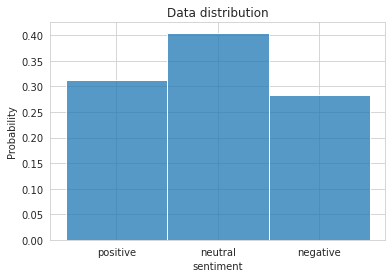

In [39]:
plot = sns.histplot(train_df['sentiment'],stat="probability")
plot.set(title="Data distribution")

In [40]:
# Undersampling to equalize the number of samples for each target value. 

n = len(train_df[train_df['sentiment']=='negative'])

df_0 = train_df[train_df['sentiment']=='neutral']
df_1 = train_df[train_df['sentiment']=='positive']
df_2 = train_df[train_df['sentiment']=='negative']

df_undersample = pd.concat([df_0.sample(n) , df_1.sample(n)])
df_undersample = pd.concat([df_undersample,df_2])

train_df = df_undersample

[Text(0.5, 1.0, 'Data distribution')]

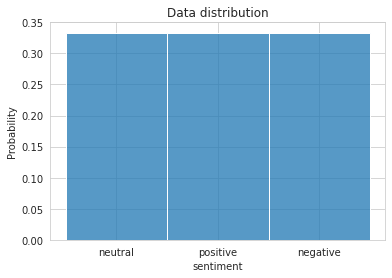

In [41]:
plot = sns.histplot(train_df['sentiment'],stat="probability")
plot.set(title="Data distribution")

<h4> Distribution of the length of the tweets </h4>

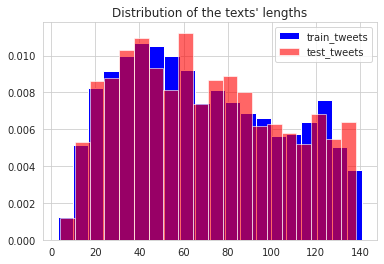

In [42]:
length_train=train_df['text'].str.len()
length_test=test_df['text'].str.len()
plt.hist(length_train, bins=20, density=True,color="blue", label="train_tweets")
plt.hist(length_test, bins=20, density=True,alpha=0.6, color="red",label="test_tweets")
plt.title("Distribution of the texts' lengths")
plt.legend()
plt.show()

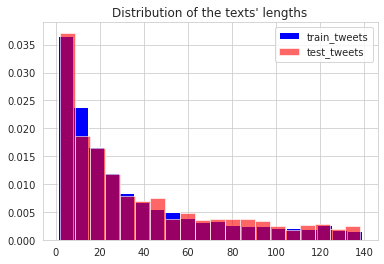

In [43]:
length_train=train_df['selected_text'].str.len()
length_test=test_df['selected_text'].str.len()
plt.hist(length_train, bins=20, density=True,color="blue", label="train_tweets")
plt.hist(length_test, bins=20, density=True,alpha=0.6, color="red",label="test_tweets")
plt.title("Distribution of the texts' lengths")
plt.legend()
plt.show()

The distribution of the length of the texts is approximately similar in the training and testing sets.

<h2> Data preprocessing </h2>

In [44]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=0)

We start off by converting the labels to numbers. This is a requirement for the submission and numerical inputs are generally more compatible with machine learning libraries.

In [45]:
target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': -1
}

In [46]:
train_df['target'] = train_df['sentiment'].map(target_conversion)
val_df['target'] = val_df['sentiment'].map(target_conversion)

In [47]:
train_df.head()

,textID,text,selected_text,sentiment,target
23594,8e455207d3,So I love my mac but msn doesn`t work on it still,So I love my mac but msn doesn`t work on it still,neutral,0
18864,16ac6a718b,Oh THOSE messages. Probably not,Oh THOSE messages. Probably not,neutral,0
8192,021f526c3c,This is the last time to get it right... hell...,hello loves....,positive,1
9302,afbbb3201f,I`m not off till 930,I`m not off till 930,neutral,0
16108,b4519e30b1,Really? 87 degrees as the high and I`m on my w...,Really? 87 degrees as the high and I`m on my w...,negative,-1


<h3> Data Cleaning </h3>

In [48]:
#Data cleaning

train_df['text'] = train_df['text'].str.lower()
val_df['text'] = val_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

train_df['text'] = train_df['text'].str.replace("#", " ") #remove hashtags
val_df['text'] = val_df['text'].str.replace("#", " ") #remove hashtags
test_df['text'] = test_df['text'].str.replace("#", " ") #remove hashtags

apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [49]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word in dictionary:
            if word in text.split():
                text = text.replace(word, dictionary[word])
    return text

In [50]:
train_df['text'] = train_df['text'].apply(lambda x: lookup_dict(x,apostrophe_dict))
val_df['text'] = val_df['text'].apply(lambda x: lookup_dict(x,apostrophe_dict))
test_df['text'] = test_df['text'].apply(lambda x: lookup_dict(x,apostrophe_dict))

train_df['text'] = train_df['text'].apply(lambda x: lookup_dict(x,short_word_dict))
val_df['text'] = val_df['text'].apply(lambda x: lookup_dict(x,short_word_dict))
test_df['text'] = test_df['text'].apply(lambda x: lookup_dict(x,short_word_dict))

train_df['text'] = train_df['text'].apply(lambda x: lookup_dict(x,emoticon_dict))
val_df['text'] = val_df['text'].apply(lambda x: lookup_dict(x,emoticon_dict))
test_df['text'] = test_df['text'].apply(lambda x: lookup_dict(x,emoticon_dict))

In [51]:
stop_words = set(stopwords.words("english"))
train_df['text'] = train_df['text'].apply(lambda x : " ".join(word for word in x.split() if word not in stop_words ))
val_df['text'] = val_df['text'].apply(lambda x : " ".join(word for word in x.split() if word not in stop_words ))
test_df['text'] = test_df['text'].apply(lambda x : " ".join(word for word in x.split() if word not in stop_words ))

<h2> Predicting sentiment using TextBlob </h2>

In [52]:
from textblob import TextBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tb_val = val_df
tb_val["polarity"] = tb_val['text'].apply(getPolarity)

def getAnalysis(score):
    if score<0:
        return(-1)
    if score>0:
        return(1)
    return(0)

y_pred = tb_val["polarity"].apply(getAnalysis)

fbeta = fbeta_score(tb_val['target'].values, y_pred, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.5866968826847987


<h3> Back to preprocessing: transforming the input data into numerical features </h3>

We are using the Bag-of-Words method for feature extraction

In [53]:
count_vect = CountVectorizer()

In [54]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['text'].values))
X_val_counts = count_vect.transform(list(val_df['text'].values))
X_test_counts = count_vect.transform(list(test_df['text'].values))

In [55]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

Train feature shape: (18908, 21282)
Train feature shape: (2101, 21282)
Test feature shape: (2748, 21282)


<h2> Training a naive Bayes classifier </h2> 

In [56]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

CPU times: user 5.73 ms, sys: 3.1 ms, total: 8.83 ms
Wall time: 8.33 ms


In [57]:
val_predictions_nb = clf.predict(X_val_counts)

In [58]:
accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier is: {:.2f}%'.format(accuracy*100))

The accuracy of our multinomial Naive Bayes classifier is: 65.45%


In [59]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.646847981597814


<AxesSubplot:>

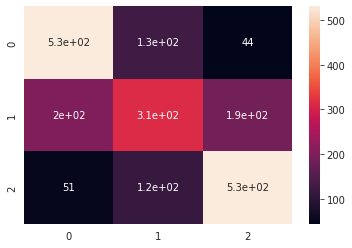

In [60]:
cm = confusion_matrix(val_df['target'].values, val_predictions_nb)
sns.heatmap(cm, annot=True)

<h2> Training a SVM classifier </h2>

In [73]:
#Training the default SVM classifier

ml = svm.SVC(C=100,gamma=0.1) 
ml.fit(X_train_counts, train_df['target'])
val_predictions_svm=ml.predict(X_val_counts)

accuracy = (val_predictions_svm == val_df['target'].values).mean()
print('The accuracy of the SVM model is: {:.2f}%'.format(accuracy*100))

fbeta = fbeta_score(val_df['target'].values, val_predictions_svm, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The accuracy of our multinomial Naive Bayes classifier is: 69.35%
The fbeta score is: 0.6969761360283907


In [74]:
#Hyper parameter tuning 

"""ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=15)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_counts, train_df['target'])
print(grid_search.best_params_)"""

Fitting 15 folds for each of 25 candidates, totalling 375 fits


KeyboardInterrupt: 

In [ ]:
"""val_predictions_svm=grid.predict(X_val_counts)


accuracy = (val_predictions_svm == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier is: {:.2f}%'.format(accuracy*100))

fbeta = fbeta_score(val_df['target'].values, val_predictions_svm, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)"""

In [ ]:
cm_svm = confusion_matrix(val_df['target'].values, val_predictions_svm)
sns.heatmap(cm, annot=True)

In [ ]:
# Creating a submission

X_train_counts = count_vect.fit_transform(list(train_df['text'].values) + list(val_df['text'].values))
X_test_counts = count_vect.transform(list(test_df['text'].values))

ml = svm.SVC(C=, kernel='rbf', gamma=) 
ml.fit(X_train_counts, train_df['target'])
val_predictions_svm = ml.predict(X_test_counts)

submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = test_predictions_nb
submission_df.to_csv('Group15_Submission.csv', index=False)

## How good is this score?

Early approaches in NLP used rule-based classifiers for sentiment analysis. A popular baseline is VADER which was published in 2014:

https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/viewPaper/8109

VADER does not use any machine learning but is purely handcrafted by humans. It uses text preprocessing and lexica to determine the sentiment of a text.

In [63]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
sid = SentimentIntensityAnalyzer()

In [65]:
# We show a few prediction examples:
for doc in val_df['text'].iloc[:5].values:
    print(doc)
    print(sid.polarity_scores(doc))

oh wait, messed messed lyrics, 'don`t concretize it'
{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.5859}
super stressful day & can`t sleep...glad found sweet take time make strangers feel good.
{'neg': 0.149, 'neu': 0.407, 'pos': 0.443, 'compound': 0.7579}
went world education fair today. whole different kind circus.
{'neg': 0.0, 'neu': 0.551, 'pos': 0.449, 'compound': 0.6908}
http://twitpic.com/4j9fb - really love picture!
{'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.6989}
great day
{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}


In [66]:
def vader_predict(x):
    prediction = sid.polarity_scores(x)
    prediction_list = [
        (1, prediction['pos']),
        (-1, prediction['neg']),
        (0, prediction['neu'])
    ]
    label = sorted(prediction_list, key=lambda x: x[1], reverse=True)[0][0]
    return label

In [67]:
predictions_vader = val_df['text'].apply(vader_predict)

In [68]:
accuracy = (predictions_vader == val_df['target'].values).mean()
print('The accuracy of VADER is: {:.2f}%'.format(accuracy*100))

The accuracy of VADER is: 49.98%


In [69]:
fbeta = fbeta_score(val_df['target'].values, predictions_vader, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.4652587255617801


VADER performs worse! That is a good sign that our classifier learned useful generalizations from the training data (better than standard handcrafted rules).